<a href="https://colab.research.google.com/github/ComponentSoftTeam/Mistral-Kubectl-Instruct/blob/main/notebooks/Deep_Learning_Demo_extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training

## Setup

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torchvision
import numpy as np
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Standardize random numbers for reproducibility
torch.manual_seed(0)
# Set grayscale as default
plt.gray()

<Figure size 640x480 with 0 Axes>

In [18]:
def display_model_weights(model):
  fc1_weights = model.fc1.weight.data.cpu().numpy()
  fc2_weights = model.fc2.weight.data.cpu().numpy()

  # Visualize the weights of the first linear layer
  plt.figure(figsize=(10, 2))
  plt.imshow(fc1_weights, cmap='viridis', aspect='auto')
  plt.colorbar()
  plt.title('Weights of Linear Layer 1')
  plt.xlabel('Neuron Index')
  plt.ylabel('Input Dimension')
  plt.show()

  # Visualize the weights of the second linear layer
  plt.figure(figsize=(10, 2))
  plt.imshow(fc2_weights, cmap='viridis', aspect='auto')
  plt.colorbar()
  plt.title('Weights of Linear Layer 2')
  plt.xlabel('Neuron Index')
  plt.ylabel('Input Dimension')
  plt.show()

## Train

Label: 5


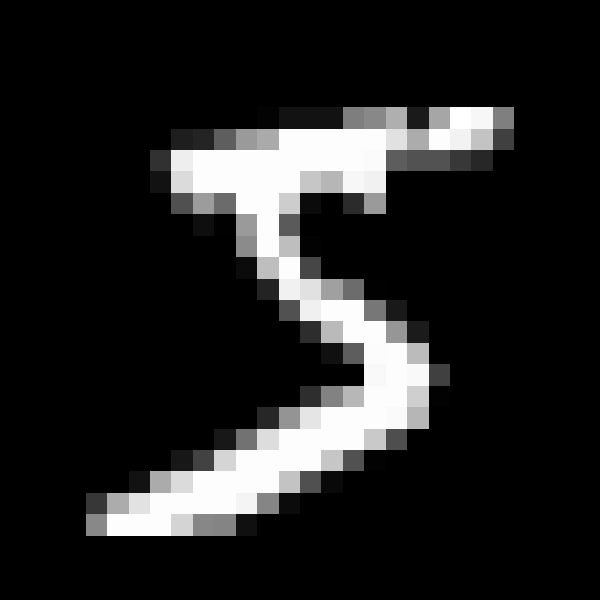

In [2]:
import PIL
img, label = torchvision.datasets.MNIST(root='../data', train=True, download=True)[0]
# Resizing for illustration porposes, because the images are 28 x 28 each
img = img.resize((600, 600), resample=PIL.Image.Resampling.NEAREST)
print(f"Label: {label}")
img

In [3]:
# input layer, a single hidden layer, and an output layer
# Define hyperparameters
input_size = 784  # 28x28 pixels
hidden_size = 128
num_classes = 10
batch_size = 100

In [4]:
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
means = [img.mean() for img, label in train_dataset]
mean = sum(means) / len(means)
sd = (sum([((img - mean)**2).sum() for img, label in train_dataset]) / (len(means) * 28 * 28))**0.5
print((mean, sd))

(tensor(0.1307), tensor(0.3081))


In [5]:
# Load MNIST dataset
transform = transforms.Compose(
    [
        transforms.ToTensor(),                      # convert to pytorch tensor
        transforms.Normalize((0.1307,), (0.3081,))  # standardize the values with mean + std
    ]
)

train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Define the neural network model
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Create the model
model = NeuralNet(input_size, hidden_size, num_classes)

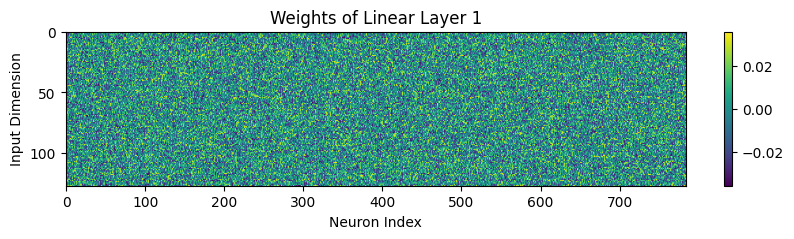

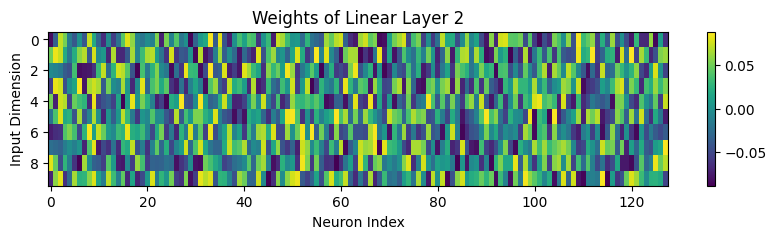

In [7]:
display_model_weights(model)

In [8]:
# Loss function options
cross_entropy_loss = nn.CrossEntropyLoss()
nll_loss = nn.NLLLoss()
mse_loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
input_size

784

In [10]:
# Function to train the model
def train_model(model, loss_function, train_loader, optimizer, num_epochs=10):
    # Put the model in training mode
    model.train()

    # Iterate over the number of epochs
    for epoch in range(num_epochs):
        # Initialize the running loss for this epoch to zero
        running_loss = 0.0

        # Iterate over each batch in the training loader
        for i, (images, labels) in enumerate(train_loader):

            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)
            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)
            # Compute the loss between the outputs and the true labels
            loss = loss_function(outputs, labels)
            # Backward pass: compute the gradients of the loss with respect to the model parameters
            optimizer.zero_grad()
            loss.backward()
            # Update the model parameters using the optimizer
            optimizer.step()

            # Add the current batch loss to the running loss for this epoch
            running_loss += loss.item()

        # Compute the average loss over all batches for this epoch and print it
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


In [11]:
# Function to evaluate the model
def evaluate_model(model, test_loader):
    # Put the model in evaluation mode
    model.eval()

    # Initialize empty lists to store true and predicted labels
    y_true, y_pred = [], []

    # Disable gradient computation since we're only evaluating the model
    with torch.no_grad():
        # Iterate over each batch in the test loader
        for images, labels in test_loader:
            # Reshape the images tensor to have size (batch_size, input_size)
            images = images.reshape(-1, input_size)

            # Forward pass: compute the outputs of the model given the input images
            outputs = model(images)

            # Find the predicted class for each image in the batch
            _, predicted = torch.max(outputs.data, 1)

            # Append the true and predicted labels for this batch to the lists
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    # Calculate evaluation metrics using the true and predicted labels
    accuracy, f1, precision, recall = evaluate_model_metrics(np.array(y_true), np.array(y_pred))

    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Function to calculate evaluation metrics
def evaluate_model_metrics(y_true, y_pred):
    # Compute the accuracy, F1 score, precision, and recall
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    # Return the evaluation metrics
    return accuracy, f1, precision, recall

# Define a dictionary of loss functions
loss_functions = {
    'CrossEntropyLoss': nn.CrossEntropyLoss(),
    'NLLLoss': nn.NLLLoss(),  # requires logsoftmax output (according to docs, so loss will be wrong without it!)
    'MultiMarginLoss': nn.MultiMarginLoss()
}

In [12]:
# Train and evaluate the model using different loss functions
for loss_name, loss_function in loss_functions.items():
    print(f'Training with {loss_name}:')

    # Initialize a new model and optimizer for each loss function
    model = NeuralNet(input_size, hidden_size, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, loss_function, train_loader, optimizer, num_epochs=5)

    # Evaluate the model
    accuracy, f1, precision, recall = evaluate_model(model, test_loader)
    print(f'Performance metrics for {loss_name}:')
    print(f'Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}\n')


Training with CrossEntropyLoss:
Epoch [1/5], Loss: 0.2834
Epoch [2/5], Loss: 0.1256
Epoch [3/5], Loss: 0.0887
Epoch [4/5], Loss: 0.0660
Epoch [5/5], Loss: 0.0540
Performance metrics for CrossEntropyLoss:
Accuracy: 0.9765, F1-score: 0.9763, Precision: 0.9763, Recall: 0.9764

Training with NLLLoss:
Epoch [1/5], Loss: -11650.4495
Epoch [2/5], Loss: -82348.7300
Epoch [3/5], Loss: -213638.1270
Epoch [4/5], Loss: -395371.2482
Epoch [5/5], Loss: -620878.4007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance metrics for NLLLoss:
Accuracy: 0.1009, F1-score: 0.0183, Precision: 0.0101, Recall: 0.1000

Training with MultiMarginLoss:
Epoch [1/5], Loss: 0.0425
Epoch [2/5], Loss: 0.0159
Epoch [3/5], Loss: 0.0106
Epoch [4/5], Loss: 0.0078
Epoch [5/5], Loss: 0.0062
Performance metrics for MultiMarginLoss:
Accuracy: 0.9754, F1-score: 0.9753, Precision: 0.9757, Recall: 0.9751



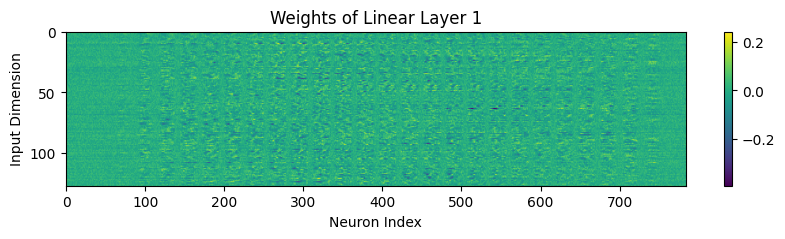

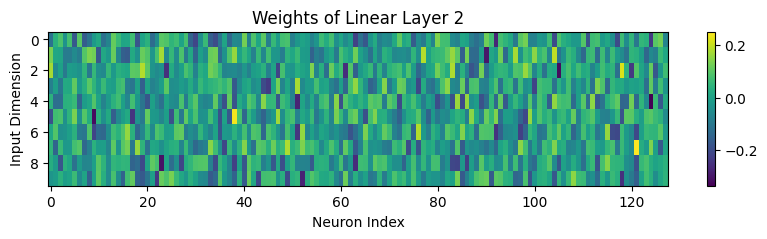

In [19]:
display_model_weights(model)

# Inference

## Setup

In [13]:
class IterativeRenderer:
  def __init__(self):
    self.chunk_rows = 2
    self.chunk_cols = 8
    self.chunk_size = self.chunk_rows * self.chunk_cols
    self.current_chunk = -1
    self.imgs = None
    self.last_patch = None
    self.fig = None
    self.axes = None
    self.created = False

  def load_img_chunk(self, chunk_index):
    return [(np.squeeze(np.transpose(test_dataset[chunk_index * self.chunk_size + j][0], (1, 2, 0))), test_dataset[chunk_index * self.chunk_size + j][1]) for j in range(self.chunk_size)]

  def render_chunk(self, i):

    self.fig, self.axes = plt.subplots(nrows=self.chunk_rows, ncols=self.chunk_cols, figsize=(self.chunk_cols*2, self.chunk_rows*2))

    chunk_index = i // self.chunk_size
    i = i % self.chunk_size

    if self.last_patch:
      self.last_patch.remove()

    if chunk_index != self.current_chunk:
      imgs = self.load_img_chunk(chunk_index)
      chunk_index = self.current_chunk

      for row in range(self.chunk_rows):
        for col in range(self.chunk_cols):
          index = row * self.chunk_cols + col
          ax = self.axes[row, col]
          img, label = imgs[index]

          ax.imshow(img)
          ax.set_title(f'Label: {label}', fontsize=8)
          ax.axis('off')

          if i == index:
            x0, x1, y0, y1 = ax.axis()
            rec = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, lw=4, edgecolor='cyan')
            self.last_patch = ax.add_patch(rec)
            self.last_patch.set_clip_on(False)

    else:
      chunk_row = i // self.chunk_cols
      chunk_col = i % self.chunk_cols
      ax = self.axes[chunk_row, chunk_col]

      x0, x1, y0, y1 = ax.axis()
      rec = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, lw=4, edgecolor='cyan')
      self.last_patch = ax.add_patch(rec)
      self.last_patch.set_clip_on(False)

    self.fig.tight_layout(pad=2)
    plt.show()

iterative_renderer = IterativeRenderer()

In [14]:
def display_prediction(i, width_limit = 160):
  iterative_renderer.render_chunk(i)
  test = test_dataset[i][0]
  test = test.reshape(-1, input_size)

  prediction = model(test)
  prediction = torch.nn.functional.softmax(prediction, dim=1)[0]

  print("")
  for i, val in enumerate(prediction.tolist()):
    print("{}\t{:.6f} {}".format(i, val, "#"*min(round(width_limit*val), width_limit)))

  print(f"\nmax: \t{torch.max(prediction, 0)[1].item()}")

## Examples

In [24]:
display_index = 8

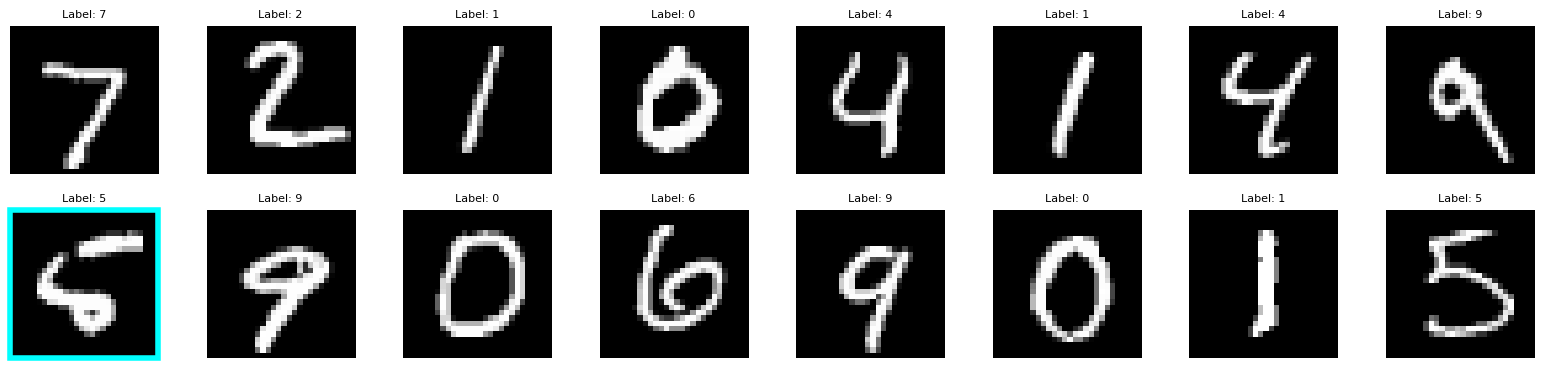


0	0.000281 
1	0.002586 
2	0.011925 ##
3	0.000128 
4	0.006004 #
5	0.791126 ###############################################################################################################################
6	0.185498 ##############################
7	0.000185 
8	0.001368 
9	0.000900 

max: 	5


In [25]:
display_prediction(display_index)
display_index += 1